<a href="https://colab.research.google.com/github/victoralcantara75/CNN-FLOWER-CLASSIFY/blob/master/CNN_FLOWER_CLASSIFY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CNN PARA CLASSIFICAÇÃO DE FLORES
## SIN493 - DEEP LEARNING PARA VISÃO COMPUTACIONAL

##PYTORCH/CUDA/PIL/IMPORTS

In [0]:
!pip uninstall -y Pillow
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl


5.3.0


In [0]:
#http://pytorch.org/

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

    100% |████████████████████████████████| 512.6MB 52.5MB/s 
fastai 1.0.42 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.


In [0]:
# verificando se o CUDA está disponível
GPUavailable = torch.cuda.is_available()

if GPUavailable:
    print('Treinamento em GPU!')
    device = torch.device("cuda:0")
else:
    print('Treinamento em CPU!')
    device = "cpu"

Treinamento em GPU!


In [0]:
#IMPORTACOES NECESSARIAS
import os
import numpy as np
import torch
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import torch.nn as nn 
import torch.optim as optim
from PIL import Image
from torch.autograd import Variable
import torch.nn.functional as F

##DATASET

In [0]:
#BAIXANDO DATASET 
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!unzip -qq flower_data.zip

In [0]:
#PEGANDO DIRETORIO DO DATASET DE TREINO E TESTE
diretorio_dados = 'flower_data'
diretorio_treino = diretorio_dados + '/train'
diretorio_validacao = diretorio_dados + '/valid'

In [0]:
# APLICANDO AS TRANSFORMACOES NECESSARIAS E O DATA AUGMENTATION

transformacao_treino = transforms.Compose([ 
                       transforms.RandomRotation(10),      #ROTAÇÃO DAS IMAGENS
                       transforms.RandomResizedCrop(224),  #INPUT SIZE 224X224
                       transforms.RandomHorizontalFlip(),  #ESPELHAMENTO
                       transforms.ToTensor(),
                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])
transformacao_teste = transforms.Compose([ 
                          transforms.Resize(224),
                          transforms.RandomResizedCrop(224),
                          transforms.ToTensor(),
                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])


In [0]:
#PASSANDO OS DATASETS PARA OS VETORES (TREINO E TESTE)
dados_treino = datasets.ImageFolder(diretorio_treino, transformacao_treino)
dados_teste = datasets.ImageFolder(diretorio_validacao, transformacao_teste)

print('Numero de imagens de treino: ', len(dados_treino))
print('Numero de imagens de teste: ', len(dados_teste))

Numero de imagens de treino:  6552
Numero de imagens de teste:  818


In [0]:
# Data Loaders e Visualização

batch_size = 20
num_workers=4
validacao = 0.2

# obter os índices de treinamento que serão usados para validação
indices = list(range(len(dados_treino)))
np.random.shuffle(indices)
split = int(np.floor(validacao * len(dados_treino)))
treino_idx, valid_idx = indices[split:], indices[:split]

# definir os samplers para obter lotes de treinamento e validação
sampler_treino = SubsetRandomSampler(treino_idx)
sampler_valid = SubsetRandomSampler(valid_idx)

# dataloaders
treino_loader = torch.utils.data.DataLoader(dados_treino, batch_size=batch_size, num_workers=num_workers, sampler = sampler_treino)
validacao_loader = torch.utils.data.DataLoader(dados_treino, batch_size=batch_size, num_workers=num_workers, sampler=sampler_valid)
teste_loader = torch.utils.data.DataLoader(dados_teste, batch_size=batch_size,num_workers=num_workers, shuffle=True)

classes = dados_treino.classes
print(classes)

['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


In [0]:
#MAPEANDO OS LABELS
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

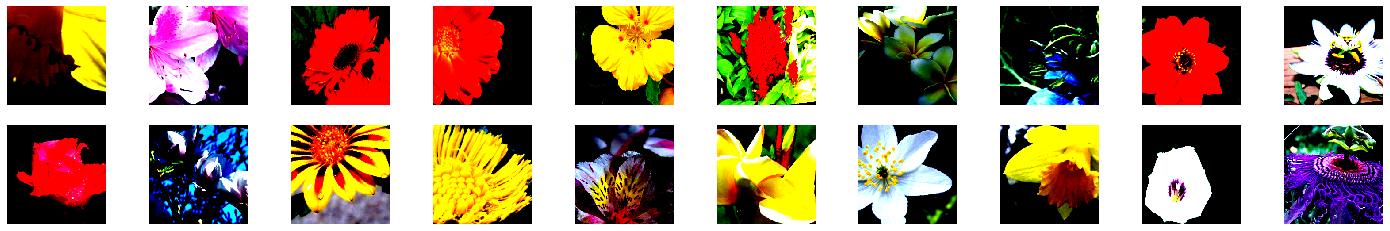

In [0]:
# obtendo um batch de imagens de treinamento
dataiter = iter(treino_loader)
images, labels = dataiter.next()
images = images.numpy() # para exibir as imagens converter para numpy

# plotar as imagens no batch, com os rótulos correspondentes
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))

##TREINO E CLASSIFICACAO VGG

In [0]:
#criando o modelo de vgg 16 pre treinada
VGG = models.vgg16(pretrained=True)
print('Arquitetura VGG-16:')
print(VGG)

# movendo os tensors para GPU se o CUDA estiver disponível
if GPUavailable:
    VGG.cuda()
    print('VGG no cuda')


In [0]:
# Congelar o treinamento para todas as camadas de características
for param in VGG.features.parameters():
    param.requires_grad = False

In [0]:
n_inputs = VGG.classifier[6].in_features

# adicionar a última camada para 102 classes
# novas camadas automaticamente tem requires_grad = True
last_layer = nn.Linear(n_inputs, 102)

VGG.classifier[6] = last_layer

# verifique se sua última camada produz o número esperado de saídas
print('Numero de classes de saída: ')
print(VGG.classifier[6].out_features)

Numero de classes de saída: 
102


In [0]:
# Especificando a loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# Definindo o Otimizador
optimizer = optim.Adam(VGG.parameters(), lr=0.001)

In [0]:
#TREINAMENTO 

VGG.to('cuda')

epocas = 20
valid_loss_min = np.Inf # acompanhar a mudança na validação (loss)

for epocas in range (1, epocas+1):

  treino_loss = 0.0
  t_loss = 0.0
  validacao_loss = 0.0
  
  # ============= TREINO ===============
  VGG.train()
  for batch_i, (data, target) in enumerate(treino_loader):
        
        if GPUavailable:
            data, target = data.cuda(), target.cuda()
            
        optimizer.zero_grad()
        output = VGG(data)
        loss = criterion(output, target)               #batch loss
        loss.backward()
        optimizer.step()                               #otimizador SGD 
        treino_loss += loss.item()*data.size(0)        #atualizacao do treinamento
        t_loss += loss.item()*data.size(0)
        
        if batch_i % 20 == 19:
          print('Época %d, Batch %d loss: %.16f' % (epocas, batch_i + 1, t_loss / 20))
        t_loss = 0.0
        
        
  # ============ VALIDACAO ==============
  VGG.eval()
  for data, target in validacao_loader:
      
      if GPUavailable:
            data, target = data.cuda(), target.cuda()
          
      output = VGG(data)
      loss = criterion(output, target)
      validacao_loss += loss.item()*data.size(0)

  # Calcular as perdas médias (losses)
  treino_loss = treino_loss/len(treino_loader.dataset)
  validacao_loss = validacao_loss/len(validacao_loader.dataset)
        
    
#   Impressão das estatísticas de treinamento/validação
#   print('Época: {} \tTreinamento Loss: {:.6f} \tValidacao Loss: {:.6f}'.format(
#         epocas, treino_loss, validacao_loss))
    
  # Salvar o modelo se a perda da valiaçaõ tiver reduzido
  if validacao_loss <= valid_loss_min:
      print('Validacao loss decrementou ({:.6f} --> {:.6f}).  Salvando o modelo ...'.format(valid_loss_min,validacao_loss))
      torch.save(VGG.state_dict(), 'model102.pt')
      valid_loss_min = validacao_loss
        
 

Época 1, Batch 20 loss: 5.3244009017944336
Época 1, Batch 40 loss: 4.2345108985900879
Época 1, Batch 60 loss: 3.8626029491424561
Época 1, Batch 80 loss: 3.6745409965515137
Época 1, Batch 100 loss: 3.4177250862121582
Época 1, Batch 120 loss: 3.0457935333251953
Época 1, Batch 140 loss: 3.0648779869079590
Época 1, Batch 160 loss: 2.7144279479980469
Época 1, Batch 180 loss: 2.9577901363372803
Época 1, Batch 200 loss: 3.5870883464813232
Época 1, Batch 220 loss: 2.7797920703887939
Época 1, Batch 240 loss: 3.3791394233703613
Época 1, Batch 260 loss: 2.6586909294128418
Validacao loss decrementou (inf --> 0.449156).  Salvando o modelo ...
Época 2, Batch 20 loss: 2.0611054897308350
Época 2, Batch 40 loss: 3.5274868011474609
Época 2, Batch 60 loss: 2.5303649902343750


In [0]:
VGG.load_state_dict(torch.load('model102.pt'))

In [0]:
#TESTE

test_loss = 0.0
class_correct = list(0. for i in range(102))
class_total = list(0. for i in range(102))

VGG.eval()

for data, target in teste_loader:
    if GPUavailable:
        data, target = data.cuda(), target.cuda()
   
    output = VGG(data)
    loss = criterion(output, target)           #test loss
    test_loss += loss.item()*data.size(0)      #atualizando loss
    _, pred = torch.max(output, 1)    
    correct_tensor = pred.eq(target.data.view_as(pred))    #comparando respostas corretas
    correct = np.squeeze(correct_tensor.numpy()) if not GPUavailable else np.squeeze(correct_tensor.cpu().numpy())
   
    # calculando acurácia do teste
    for i in range(batch_size-2):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
# calculando avg teste loss
test_loss = test_loss/len(teste_loader.dataset)
print('Teste Loss: {:.6f}\n'.format(test_loss))

for i in range(102):
    if class_total[i] > 0:
        print('Acurácia do teste classe %5s: %2d%% (%2d/%2d)' % (str(i), 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Acurácia do teste classe %5s: N/A (sem exemplos de treinamento)')

print('\nAcurácia Total: %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
        

Teste Loss: 0.606315

Acurácia do teste classe     0: 87% ( 7/ 8)
Acurácia do teste classe     1: 50% ( 2/ 4)
Acurácia do teste classe     2: 80% ( 4/ 5)
Acurácia do teste classe     3: 50% ( 2/ 4)
Acurácia do teste classe     4: 100% ( 6/ 6)
Acurácia do teste classe     5: 100% ( 9/ 9)
Acurácia do teste classe     6: 100% ( 5/ 5)
Acurácia do teste classe     7: 66% ( 2/ 3)
Acurácia do teste classe %5s: N/A (sem exemplos de treinamento)
Acurácia do teste classe     9: 85% ( 6/ 7)
Acurácia do teste classe    10: 100% ( 2/ 2)
Acurácia do teste classe    11: 100% (12/12)
Acurácia do teste classe    12: 81% ( 9/11)
Acurácia do teste classe    13: 50% ( 2/ 4)
Acurácia do teste classe    14: 100% ( 5/ 5)
Acurácia do teste classe    15: 100% ( 6/ 6)
Acurácia do teste classe    16: 66% ( 2/ 3)
Acurácia do teste classe    17: 100% ( 7/ 7)
Acurácia do teste classe    18: 90% ( 9/10)
Acurácia do teste classe    19: 100% ( 5/ 5)
Acurácia do teste classe    20: 50% ( 1/ 2)
Acurácia do teste classe 

##TREINO E CLASSIFICAÇÃO RESNET

In [0]:
#criando o modelo de resnet pre treinada
resnet = models.resnet18(pretrained=True)
print('Arquitetura RESNET-18:')
print(resnet)

# movendo os tensors para GPU se o CUDA estiver disponível
if GPUavailable:
    resnet.cuda()

In [0]:
# Especificando a loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# Definindo o Otimizador
optimizer = optim.SGD(resnet.parameters(), lr=0.01)

In [0]:
#TREINAMENTO 

resnet.to('cuda')

epocas = 2
valid_loss_min = np.Inf # acompanhar a mudança na validação (loss)

for epocas in range (1, epocas+1):

  treino_loss = 0.0
  t_loss = 0.0
  validacao_loss = 0.0
  
  # ============= TREINO ===============
  resnet.train()
  for batch_i, (data, target) in enumerate(treino_loader):
        
        if GPUavailable:
            data, target = data.cuda(), target.cuda()
            
        optimizer.zero_grad()
        output = resnet(data)
        loss = criterion(output, target)               #batch loss
        loss.backward()
        optimizer.step()                               #otimizador SGD 
        treino_loss += loss.item()*data.size(0)        #atualizacao do treinamento
        t_loss += loss.item()*data.size(0)
        
        if batch_i % 20 == 19:
          print('Época %d, Batch %d loss: %.16f' % (epocas, batch_i + 1, t_loss / 20))
        t_loss = 0.0
        
        
  # ============ VALIDACAO ==============
  resnet.eval()
  for data, target in validacao_loader:
      
      if GPUavailable:
            data, target = data.cuda(), target.cuda()
          
      output = resnet(data)
      loss = criterion(output, target)
      validacao_loss += loss.item()*data.size(0)

  # Calcular as perdas médias (losses)
  treino_loss = treino_loss/len(treino_loader.dataset)
  validacao_loss = validacao_loss/len(validacao_loader.dataset)
        
    
#   Impressão das estatísticas de treinamento/validação
#   print('Época: {} \tTreinamento Loss: {:.6f} \tValidacao Loss: {:.6f}'.format(
#         epocas, treino_loss, validacao_loss))
    
  # Salvar o modelo se a perda da valiaçaõ tiver reduzido
  if validacao_loss <= valid_loss_min:
      print('Validacao loss decrementou ({:.6f} --> {:.6f}).  Salvando o modelo ...'.format(valid_loss_min,validacao_loss))
      torch.save(resnet.state_dict(), 'model102.pt')
      valid_loss_min = validacao_loss

Época 1, Batch 20 loss: 5.7091698646545410
Época 1, Batch 40 loss: 6.5103826522827148
Época 1, Batch 60 loss: 4.1118273735046387
Época 1, Batch 80 loss: 3.9946284294128418
Época 1, Batch 100 loss: 3.4450583457946777
Época 1, Batch 120 loss: 2.3098099231719971
Época 1, Batch 140 loss: 1.9054629802703857
Época 1, Batch 160 loss: 2.8569424152374268
Época 1, Batch 180 loss: 1.9512498378753662
Época 1, Batch 200 loss: 1.5626064538955688
Época 1, Batch 220 loss: 1.1936802864074707
Época 1, Batch 240 loss: 1.3301461935043335
Época 1, Batch 260 loss: 2.2709419727325439
Validacao loss decrementou (inf --> 0.332170).  Salvando o modelo ...
Época 2, Batch 20 loss: 1.1059763431549072
Época 2, Batch 40 loss: 1.1422271728515625
Época 2, Batch 60 loss: 1.8024241924285889
Época 2, Batch 80 loss: 1.4711132049560547
Época 2, Batch 100 loss: 0.6784950494766235
Época 2, Batch 120 loss: 1.8942025899887085
Época 2, Batch 140 loss: 0.9006695747375488
Época 2, Batch 160 loss: 0.8726016879081726
Época 2, Batch

In [0]:
resnet.load_state_dict(torch.load('model102.pt'))

In [0]:
#TESTE

test_loss = 0.0
class_correct = list(0. for i in range(102))
class_total = list(0. for i in range(102))

resnet.eval()

for data, target in teste_loader:
    if GPUavailable:
        data, target = data.cuda(), target.cuda()
   
    output = resnet(data)
    loss = criterion(output, target)           #test loss
    test_loss += loss.item()*data.size(0)      #atualizando loss
    _, pred = torch.max(output, 1)    
    correct_tensor = pred.eq(target.data.view_as(pred))    #comparando respostas corretas
    correct = np.squeeze(correct_tensor.numpy()) if not GPUavailable else np.squeeze(correct_tensor.cpu().numpy())
   
    # calculando acurácia do teste
    for i in range(batch_size-2):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
        
# calculando avg teste loss
test_loss = test_loss/len(teste_loader.dataset)
print('Teste Loss: {:.6f}\n'.format(test_loss))

for i in range(102):
    if class_total[i] > 0:
        print('Acurácia do teste classe %5s: %2d%% (%2d/%2d)' % (str(i), 100 * class_correct[i] / class_total[i],np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Acurácia do teste classe %5s: N/A (sem exemplos de treinamento)')

print('\nAcurácia Total: %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Teste Loss: 1.179421

Acurácia do teste classe     0: 71% ( 5/ 7)
Acurácia do teste classe     1: 100% ( 4/ 4)
Acurácia do teste classe     2: 83% ( 5/ 6)
Acurácia do teste classe     3: 40% ( 2/ 5)
Acurácia do teste classe     4: 100% ( 4/ 4)
Acurácia do teste classe     5: 87% ( 7/ 8)
Acurácia do teste classe     6: 66% ( 2/ 3)
Acurácia do teste classe     7: 60% ( 3/ 5)
Acurácia do teste classe     8:  0% ( 0/ 1)
Acurácia do teste classe     9: 66% ( 4/ 6)
Acurácia do teste classe    10: 100% ( 2/ 2)
Acurácia do teste classe    11: 100% (15/15)
Acurácia do teste classe    12: 75% ( 6/ 8)
Acurácia do teste classe    13: 75% ( 3/ 4)
Acurácia do teste classe    14: 75% ( 3/ 4)
Acurácia do teste classe    15: 71% ( 5/ 7)
Acurácia do teste classe    16:  0% ( 0/ 2)
Acurácia do teste classe    17: 87% ( 7/ 8)
Acurácia do teste classe    18: 91% (11/12)
Acurácia do teste classe    19: 75% ( 3/ 4)
Acurácia do teste classe    20:  0% ( 0/ 1)
Acurácia do teste classe    21: 66% ( 2/ 3)
Acurác

## CLASSIFICADOR

In [0]:
def process_image(image):
   
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])
    image = preprocess(image)
    return image

In [0]:


def view_classify(img_path, prob, classes, mapping):
    
    image = Image.open(img_path)
    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    flower_name = mapping[img_path.split('/')[-2]]
    ax1.set_title(nomes_flores)
    ax1.imshow(image)
    ax1.axis('off')
    
    y_pos = np.arange(len(prob))
    ax2.barh(y_pos, prob, align='center')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(nomes_flores)
    ax2.invert_yaxis() 
    ax2.set_title('Probabilidade de Classe')



In [0]:
#PREVIENDO UMA CLASSE PARA IMAGEM DE ENTRADA

def previsao(dir_imagem, modelo, topk=5):
    
    img = Image.open(dir_imagem)
    img = process_image(img)
    
    # convertendo para 1D
    img = np.expand_dims(img, 0)
    
    img = torch.from_numpy(img)
    
    modelo.eval()
    inputs = Variable(img).to(device)
    logits = modelo.forward(inputs)
    
    ps = F.softmax(logits,dim=1)
    topk = ps.cpu().topk(topk)
    
    return (e.data.numpy().squeeze().tolist() for e in topk)

Qual rede deseja usar para o predict? (1/2) 
1 - VGG-16
2 - ResNet-18
1
Utilizando VGG


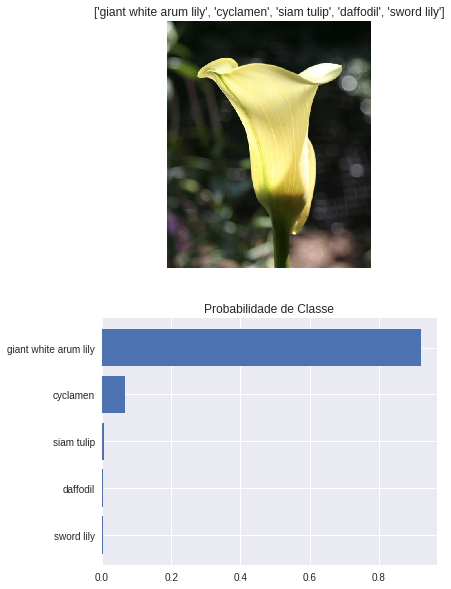

In [0]:
print('Qual rede deseja usar para o predict? (1/2) ')
print('1 - VGG-16')
print('2 - ResNet-18')
net = input()

dir_imagem = 'flower_data/valid/20/image_04903.jpg'

if net == '1':
  print('Utilizando VGG')
  probs, classes2 = previsao(dir_imagem, VGG.to(device))
elif net == '2':
  print('Utilizando ResNet')
  probs, classes2 = previsao(dir_imagem, resnet.to(device))
  
nomes_flores = [cat_to_name[classes[i]] for i in classes2]

view_classify(dir_imagem, probs, classes2, cat_to_name)